# Investigate metapath-specific p-value adjustements / thresholding

- https://github.com/greenelab/hetmech-backend/pull/41
- https://github.com/greenelab/connectivity-search-manuscript/pull/16
- [hetmatpy implementation](https://github.com/greenelab/connectivity-search-backend/blob/af12f8cf2ad47d9a25ce8d1b7889390654eb3bb9/dj_hetmech_app/management/commands/populate_database.py#L139-L146)

In [1]:
import pandas
import hetio.readwrite

In [2]:
metagraph = hetio.readwrite.read_metagraph('https://github.com/hetio/hetionet/raw/master/hetnet/json/hetionet-v1.0-metagraph.json')

In [3]:
url = 'https://github.com/greenelab/hetmech/raw/34e95b9f72f47cdeba3d51622bee31f79e9a4cb8/explore/bulk-pipeline/archives/metapath-dwpc-stats.tsv'
metapath_df = pandas.read_csv(url, sep='\t')
metapath_df['metapath_obj'] = metapath_df.metapath.map(metagraph.get_metapath)
metapath_df['source'] = metapath_df.metapath_obj.map(lambda x: x.source().identifier)
metapath_df['target'] = metapath_df.metapath_obj.map(lambda x: x.target().identifier)
metapath_df.head(2)

,metapath,length,n_pairs,pc_density,pc_mean,pc_max,dwpc-0.5_raw_mean,metapath_obj,source,target
0,AlD,1,55074,0.065403,0.065403,1,0.003746,(Anatomy - localizes - Disease),Anatomy,Disease
1,AdG,1,8419890,0.012143,0.012143,1,0.000078,(Anatomy - downregulates - Gene),Anatomy,Gene


In [4]:
# url = "https://github.com/hetio/hetionet/raw/b530811ecfac066f5bf4501a1997c1c617f8803b/describe/nodes/metanodes.tsv"
# metanode_df = pandas.read_csv(url, sep='\t')
# metanode_to_count = dict(zip(metanode_df.metanode, metanode_df.nodes))
# metanode_to_count

In [5]:
count_df = metapath_df.groupby(['source', 'target', 'length']).apply(len).rename('n_similar').reset_index()
# count_df['n_source_nodes'] = count_df.source.map(metanode_to_count)
# count_df['n_target_nodes'] = count_df.target.map(metanode_to_count)
count_df.head()

,source,target,length,n_similar
0,Anatomy,Anatomy,2,7
1,Anatomy,Anatomy,3,31
2,Anatomy,Biological Process,2,3
3,Anatomy,Biological Process,3,15
4,Anatomy,Cellular Component,2,3


In [6]:
metapath_df = metapath_df.merge(count_df)

In [7]:
metapath_df['p_threshold'] = metapath_df.eval("5 / (n_pairs * n_similar) ** 0.3")

In [8]:
metapath_df['p_threshold'].describe()

count    2205.000000
mean        0.024639
std         0.024941
min         0.002610
25%         0.007559
50%         0.015277
75%         0.033642
max         0.261179
Name: p_threshold, dtype: float64

In [9]:
pc_estimate = sum(metapath_df.n_pairs * metapath_df.p_threshold)
f'Estimated rows in the PathCounts table: {pc_estimate:,.0f}'

'Estimated rows in the PathCounts table: 596,352,570'

In [10]:
metapath_df.drop(columns='metapath_obj').sample(n=100)

,metapath,length,n_pairs,pc_density,pc_mean,pc_max,dwpc-0.5_raw_mean,source,target,n_similar,p_threshold
2115,GiG<rGpPW,3,38161790,0.279567,2.902750,37769,1.782310e-05,Gene,Pathway,47,0.008372
1308,CuGaDaG,3,32506640,0.046700,0.265250,420,1.006430e-05,Compound,Gene,216,0.005560
1513,DpCpDaG,3,2869465,0.012203,0.034064,40,3.977220e-05,Disease,Gene,225,0.011376
684,AuGcGpCC,3,559182,0.075752,4.482650,2149,7.151060e-05,Anatomy,Cellular Component,15,0.041867
1450,DpCuGuD,3,18769,0.040173,0.185892,37,9.259060e-05,Disease,Disease,67,0.073980
2185,PWpGbCiPC,3,628590,0.052494,0.207289,161,2.041700e-04,Pathway,Pharmacologic Class,3,0.065512
631,AdGiGeA,3,161604,0.051713,470.735000,102655,1.521090e-04,Anatomy,Anatomy,31,0.048868
1966,GcGcGiG,3,438693025,0.048967,0.279728,11054,8.074290e-06,Gene,Gene,199,0.002610
42,AlDrD,2,55074,0.313124,0.648128,19,3.469510e-03,Anatomy,Disease,10,0.094773
1194,CbGdAdG,3,32506640,0.581268,7.258030,743,2.336610e-05,Compound,Gene,216,0.005560


In [11]:
metapath_df.query("source == 'Gene'")

,metapath,length,n_pairs,pc_density,pc_mean,pc_max,dwpc-0.5_raw_mean,metapath_obj,source,target,n_similar,p_threshold
19,GcG,1,438693025,0.000281,0.000281,1,0.000021,(Gene - covaries - Gene),Gene,Gene,3,0.009187
20,GiG,1,438693025,0.000671,0.000671,1,0.000018,(Gene - interacts - Gene),Gene,Gene,3,0.009187
21,G<rG,1,438693025,0.000606,0.000606,1,0.000007,(Gene < regulates < Gene),Gene,Gene,3,0.009187
22,GpMF,1,60405380,0.001609,0.001609,1,0.000064,(Gene - participates - Molecular Function),Gene,Molecular Function,1,0.023155
23,GpPW,1,38161790,0.002211,0.002211,1,0.000074,(Gene - participates - Pathway),Gene,Pathway,1,0.026575
210,GdAdG,2,438693025,0.342603,0.790714,30,0.000031,"(Gene - downregulates - Anatomy, Anatomy - dow...",Gene,Gene,32,0.004516
211,GdAeG,2,438693025,0.508159,2.182800,31,0.000025,"(Gene - downregulates - Anatomy, Anatomy - exp...",Gene,Gene,32,0.004516
212,GdAuG,2,438693025,0.344844,0.704828,23,0.000031,"(Gene - downregulates - Anatomy, Anatomy - upr...",Gene,Gene,32,0.004516
213,GeAeG,2,438693025,0.712598,10.441400,83,0.000036,"(Gene - expresses - Anatomy, Anatomy - express...",Gene,Gene,32,0.004516
214,GeAuG,2,438693025,0.540892,2.148370,24,0.000027,"(Gene - expresses - Anatomy, Anatomy - upregul...",Gene,Gene,32,0.004516


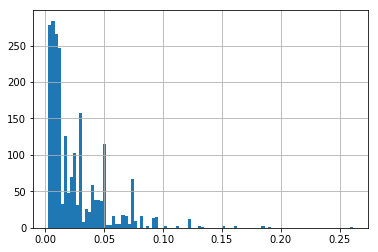

In [12]:
%matplotlib inline
metapath_df['p_threshold'].hist(bins=100)

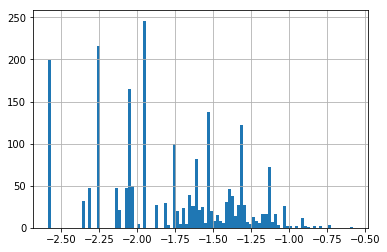

In [13]:
import math
metapath_df['p_threshold'].map(math.log10).hist(bins=100)